<a href="https://colab.research.google.com/github/Sr-Conde-Killer-Noxius/Quantum-Minds/blob/main/Backtest_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install yfinance

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

In [ ]:
# CÉLULA 2: Universo (Corrigida)
from datetime import datetime, timedelta

# Período: últimos 3 anos
# <--- MUDANÇA 1 ----
# Vamos garantir que 'end_date' não seja 'hoje' (pode bugar o yf)
# e formatar como string (mais robusto)
end_dt = datetime.today().date() - timedelta(days=1) # D-1
start_dt = end_dt - timedelta(days=365*3)

end_date = end_dt.strftime('%Y-%m-%d')
start_date = start_dt.strftime('%Y-%m-%d')
# ---- FIM DA MUDANÇA ----

# Universo (Ações B3 Agro/Proteínas):
TICKERS = [
    "SLCE3.SA", "AGRO3.SA", "SMTO3.SA",
    "JBSS3.SA", "BRFS3.SA", "MRFG3.SA",
    "BEEF3.SA", "SOJA3.SA", "KEPL3.SA",
    "FHER3.SA"
]

# Benchmarks
IBOV_TICKER = "^BVSP"
EWZ_TICKER  = "EWZ"

In [ ]:
# CÉLULA 3: Download ou Geração de Dados (Corrigida v5.5)
# Usando as datas string da Célula 2
# Corrigindo a lógica de ffill para evitar dados constantes

all_data = {}
failed_tickers_map = {}

print(f"Baixando dados de {start_date} até {end_date}...")
print("Tentando baixar tickers individuais (Modo Robusto v5.5)...")
for ticker in TICKERS:
    try:
        tk = yf.Ticker(ticker)
        # yfinance lida melhor com strings de data
        data = tk.history(start=start_date, end=end_date)

        if data.empty or 'Close' not in data.columns or data['Close'].isnull().all():
            raise Exception("Dados vazios ou coluna 'Close' ausente/NaN.")

        close_prices = data['Close']
        # <--- MUDANÇA 2: Manter o índice como datetime (não converter para .date)
        all_data[ticker] = close_prices
        print(f"  [OK] {ticker}")

    except Exception as e:
        print(f"  [FALHA] {ticker}: {e}")
        failed_tickers_map[ticker] = str(e)

if all_data:
    prices_df = pd.DataFrame(all_data)
    prices_df = prices_df[sorted(prices_df.columns)]
else:
    prices_df = pd.DataFrame(columns=TICKERS)

try:
    print("\nBaixando benchmarks...")
    ibov_data = yf.Ticker(IBOV_TICKER).history(start=start_date, end=end_date)['Close']
    ewz_data = yf.Ticker(EWZ_TICKER).history(start=start_date, end=end_date)['Close']

    available_tickers = sorted(list(prices_df.columns))
    failed_tickers = sorted(list(failed_tickers_map.keys()))

    print(f"\nAções consideradas (download OK): {available_tickers}")
    if failed_tickers:
        print(f"Tickers com falha no download (ignorados): {failed_tickers}")
        for t in failed_tickers:
           if t in failed_tickers_map:
               error_msg = str(failed_tickers_map[t]).split('\n')[0]
               print(f"    - {t} (Motivo): {error_msg}")

    MIN_STOCKS = 1
    if prices_df.empty or len(available_tickers) < MIN_STOCKS:
        raise Exception("Nenhum dado real pôde ser baixado.")

    ibov_data.name = "IBOV"
    ewz_data.name = "EWZ"

    available_benchmarks_list = []
    if not ibov_data.empty:
        available_benchmarks_list.append(ibov_data)
    if not ewz_data.empty:
        available_benchmarks_list.append(ewz_data)

    print(f"Benchmarks disponíveis: {[b.name for b in available_benchmarks_list]}")

    if available_benchmarks_list:
        prices_df = prices_df.join(available_benchmarks_list, how='outer')

    # <--- MUDANÇA 3: Normalizar fuso horário DEPOIS do join
    # Converte para UTC e remove o fuso (tz_convert(None)),
    # depois zera o horário (.normalize())
    prices_df.index = prices_df.index.tz_convert(None).normalize()

    # <--- MUDANÇA 4: Lógica de limpeza REFEITA

    # 1. Usar o IBOV para definir os dias de negociação BR
    # (Remove fins de semana e feriados BR)
    if 'IBOV' in prices_df:
        prices_df = prices_df[prices_df['IBOV'].notna()]
    else:
        # Fallback: usar dias em que *qualquer* ação negociou
        prices_df = prices_df.dropna(subset=available_tickers, how='all')

    # 2. Preencher APENAS as ações com ffill()
    # Isso preenche feriados US (onde ações BR não negociam)
    prices_df[available_tickers] = prices_df[available_tickers].ffill()

    # 3. Preencher o EWZ (para feriados BR)
    if 'EWZ' in prices_df:
        prices_df['EWZ'] = prices_df['EWZ'].ffill()

    # 4. Remover qualquer linha que ainda seja NaN (ex: início do período)
    prices_df = prices_df.dropna(how='all')

    print(f"Linhas (dias úteis) no período: {len(prices_df)}")

    # 4. Cálculo de Retornos
    returns_df = prices_df.pct_change() # .dropna(how='all') removido

    asset_returns = returns_df[available_tickers]
    benchmark_returns = returns_df[[b.name for b in available_benchmarks_list if b.name in returns_df]]

    # Limpar NaNs dos benchmarks (início do período)
    benchmark_returns = benchmark_returns.dropna(how='all')

    # NÃO limpar NaNs dos asset_returns, C4 fará isso com .fillna(0.0)

    print("\nCélula 3 (Download/Preparação de Dados Reais) concluída com sucesso.")

except Exception as e:
    print(f"\nAVISO: Falha no download dos dados reais ({e}).")
    print("Iniciando geração de dados SINTÉTICOS para o backtest.")
    # (resto do código de fallback original...)

ERROR:yfinance:$JBSS3.SA: possibly delisted; no timezone found


Baixando dados de 2022-10-27 até 2025-10-26...
Tentando baixar tickers individuais (Modo Robusto v5.5)...
  [OK] SLCE3.SA
  [OK] AGRO3.SA
  [OK] SMTO3.SA
  [FALHA] JBSS3.SA: Dados vazios ou coluna 'Close' ausente/NaN.
  [OK] BRFS3.SA
  [OK] MRFG3.SA
  [OK] BEEF3.SA
  [OK] SOJA3.SA
  [OK] KEPL3.SA
  [OK] FHER3.SA

Baixando benchmarks...

Ações consideradas (download OK): ['AGRO3.SA', 'BEEF3.SA', 'BRFS3.SA', 'FHER3.SA', 'KEPL3.SA', 'MRFG3.SA', 'SLCE3.SA', 'SMTO3.SA', 'SOJA3.SA']
Tickers com falha no download (ignorados): ['JBSS3.SA']
    - JBSS3.SA (Motivo): Dados vazios ou coluna 'Close' ausente/NaN.
Benchmarks disponíveis: ['IBOV', 'EWZ']
Linhas (dias úteis) no período: 749

Célula 3 (Download/Preparação de Dados Reais) concluída com sucesso.


/tmp/ipython-input-2973327421.py:97: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = prices_df.pct_change() # .dropna(how='all') removido


In [ ]:
# CÉLULA 4: Cálculo de Retorno Anual (Corrigido v7)
# Método vetorizado (sem .apply) para máxima estabilidade

# 1. Retorno diário (preenchido com 0.0)
ret_assets = asset_returns.fillna(0.0)

# <--- CORREÇÃO FINAL (v7) ----

# 2. Calcular os log-returns de TODO o DataFrame de uma vez
# np.log(1 + 0.0) = 0.0 (seguro)
log_ret_assets = np.log(1 + ret_assets)

# 3. Agrupar os log-returns por ano e SOMAR.
# Esta é uma operação vetorizada e robusta.
log_ret_annual = log_ret_assets.groupby(log_ret_assets.index.year).sum()

# 4. Converter as somas dos log-returns de volta para retornos anuais
ret_annual = np.exp(log_ret_annual) - 1

# ---- FIM DA CORREÇÃO ----

print("Retornos anuais (Ações) (%):")
with pd.option_context('display.float_format', None):
    display(100 * ret_annual)

Retornos anuais (Ações) (%):


,AGRO3.SA,BEEF3.SA,BRFS3.SA,FHER3.SA,KEPL3.SA,MRFG3.SA,SLCE3.SA,SMTO3.SA,SOJA3.SA
Date,,,,,,,,,
2022,2.774043,-2.556392,-32.846718,20.769232,-19.594948,-8.734185,4.733362,4.243286,-19.915240
2023,-0.228099,-39.295180,66.787440,-57.151130,18.635419,12.130007,-5.824917,14.629079,66.401011
2024,-11.652700,-31.860772,88.748894,-16.216220,-7.634391,104.873199,-2.787354,-16.836007,-35.120731
2025,-7.501219,38.899803,-29.219242,-29.516129,-12.977663,-11.743986,-6.433764,-35.553280,-1.671236


In [ ]:
# CÉLULA 5: A Seleção (Ranking) (Corrigido)
TOP_N = 10

# Itera sobre o DataFrame de retornos anuais (calculado na Célula 4)
top_by_year = {}

# <--- CORREÇÃO AQUI ----
# O índice de 'ret_annual' agora é o próprio ano (int), não mais um datetime.
# Trocamos 'dt' (que era o datetime) por 'year' (que é o int)
for year, row in ret_annual.iterrows():
    # 'year' já é o ano que queremos (ex: 2022)

    # Ordena do maior para o menor retorno
    ranked = row.dropna().sort_values(ascending=False)

    # Seleciona os TOP_N
    top_n = ranked.head(TOP_N)
    top_by_year[year] = top_n

# ---- FIM DA CORREÇÃO ----

print(f"Ranking dos Top {TOP_N} (por Retorno Anual):")
display(top_by_year)


Ranking dos Top 10 (por Retorno Anual):


{2022: FHER3.SA    0.2077
 SLCE3.SA    0.0473
 SMTO3.SA    0.0424
 AGRO3.SA    0.0277
 BEEF3.SA   -0.0256
 MRFG3.SA   -0.0873
 KEPL3.SA   -0.1959
 SOJA3.SA   -0.1992
 BRFS3.SA   -0.3285
 Name: 2022, dtype: float64,
 2023: BRFS3.SA    0.6679
 SOJA3.SA    0.6640
 KEPL3.SA    0.1864
 SMTO3.SA    0.1463
 MRFG3.SA    0.1213
 AGRO3.SA   -0.0023
 SLCE3.SA   -0.0582
 BEEF3.SA   -0.3930
 FHER3.SA   -0.5715
 Name: 2023, dtype: float64,
 2024: MRFG3.SA    1.0487
 BRFS3.SA    0.8875
 SLCE3.SA   -0.0279
 KEPL3.SA   -0.0763
 AGRO3.SA   -0.1165
 FHER3.SA   -0.1622
 SMTO3.SA   -0.1684
 BEEF3.SA   -0.3186
 SOJA3.SA   -0.3512
 Name: 2024, dtype: float64,
 2025: BEEF3.SA    0.3890
 SOJA3.SA   -0.0167
 SLCE3.SA   -0.0643
 AGRO3.SA   -0.0750
 MRFG3.SA   -0.1174
 KEPL3.SA   -0.1298
 BRFS3.SA   -0.2922
 FHER3.SA   -0.2952
 SMTO3.SA   -0.3555
 Name: 2025, dtype: float64}

In [ ]:
# CÉLULA 6: Construção da carteira (Corrigido v3)
# Padronizando o cálculo das curvas (fillna(0) antes do cumprod)

# --- Cálculo do Baseline ---
baseline_ret = pd.Series(index=asset_returns.index, dtype=float)
years = sorted(set(d.year for d in asset_returns.index))
for y in years:
    mask = asset_returns.index.year == y
    if y not in top_by_year: # top_by_year vem da Célula 5
        # Se o ano não está no ranking (ex: ano inicial parcial sem retorno 'anterior')
        # preenche com NaN ou 0.0, dependendo da sua preferência.
        # Vamos usar NaN e preencher depois para consistência.
        baseline_ret.loc[mask] = np.nan
        continue

    # Pega os 'picks' do ano ANTERIOR para aplicar no ano 'y'
    # Ex: Para simular 2023, usamos o ranking baseado no retorno de 2022.
    year_to_use_for_ranking = y - 1
    if year_to_use_for_ranking not in top_by_year:
         baseline_ret.loc[mask] = np.nan # Ou 0.0 se preferir manter caixa
         continue

    picks = [t for t in top_by_year[year_to_use_for_ranking].index if t in asset_returns.columns]
    if len(picks) == 0:
        baseline_ret.loc[mask] = np.nan # Ou 0.0
        continue

    # Calcula o retorno equal-weight dos picks no ano 'y'
    baseline_ret.loc[mask] = asset_returns.loc[mask, picks].mean(axis=1, skipna=True)

# <--- CORREÇÃO 1: Preencher TODOS os NaNs (incluindo o inicial) com 0.0 ----
baseline_ret = baseline_ret.fillna(0.0)
baseline_curve = (1 + baseline_ret).cumprod()
baseline_curve.name = "Baseline"

# --- Cálculo do Agro Proxy ---
agro_proxy_ret = asset_returns.mean(axis=1, skipna=True)
# <--- CORREÇÃO 2: Preencher o NaN inicial com 0.0 ----
agro_proxy_ret = agro_proxy_ret.fillna(0.0)
agro_proxy_curve = (1 + agro_proxy_ret).cumprod()
agro_proxy_curve.name = "Agro Proxy"

# --- Cálculo do Ibovespa ---
ibov_ret = benchmark_returns["IBOV"] # Sem dropna()
# <--- CORREÇÃO 3: Preencher o NaN inicial com 0.0 ----
ibov_ret = ibov_ret.fillna(0.0)
ibov_curve = (1 + ibov_ret).cumprod()
# Normalizar para começar em 1.0 (importante para benchmarks)
ibov_curve = ibov_curve / ibov_curve.iloc[0]
ibov_curve.name = "Ibovespa"

# --- Cálculo do EWZ (já estava robusto, pequena melhoria) ---
if "EWZ" in benchmark_returns.columns:
    ewz_ret = benchmark_returns["EWZ"].dropna()
    if ewz_ret.empty:
        print("Aviso: Nenhum dado válido encontrado para EWZ (benchmark). Ignorando EWZ.")
        ewz_curve = None
    else:
        # Preencher NaN inicial (se houver após dropna)
        ewz_ret_filled = ewz_ret.fillna(0.0)
        ewz_curve = (1 + ewz_ret_filled).cumprod()
        # Normalizar
        ewz_curve = ewz_curve / ewz_curve.iloc[0]
        ewz_curve.name = "EWZ"
else:
    ewz_curve = None
# ---- FIM DAS CORREÇÕES ----

# --- Checagem de Tamanhos ---
print("Checagem de tamanhos (Corrigido v3):")
print("Baseline:", len(baseline_curve))
print("Agro Proxy:", len(agro_proxy_curve))
print("Ibovespa:", len(ibov_curve))
if ewz_curve is not None:
    print("EWZ:", len(ewz_curve))
else:
    print("EWZ: Ignorado (dados ausentes)")

# --- Preparar dados para Célula 7 (Métricas) ---
# Juntar as curvas que realmente existem para garantir alinhamento final
curves_to_analyze = [baseline_curve, agro_proxy_curve, ibov_curve]
if ewz_curve is not None:
    curves_to_analyze.append(ewz_curve)

# Usar um join para garantir que todas começam e terminam nos mesmos dias exatos
# (embora o fillna(0) já deva ter resolvido isso)
aligned_curves_df = pd.concat(curves_to_analyze, axis=1).dropna()

# Extrair as curvas alinhadas de volta
baseline_curve_aligned = aligned_curves_df["Baseline"]
agro_proxy_curve_aligned = aligned_curves_df["Agro Proxy"]
ibov_curve_aligned = aligned_curves_df["Ibovespa"]
ewz_curve_aligned = aligned_curves_df.get("EWZ", None) # Usa .get para caso EWZ não exista

Aviso: Nenhum dado válido encontrado para EWZ (benchmark). Ignorando EWZ.
Checagem de tamanhos (Corrigido v3):
Baseline: 749
Agro Proxy: 749
Ibovespa: 748
EWZ: Ignorado (dados ausentes)


In [ ]:
import pandas as pd
import numpy as np

def max_drawdown(series: pd.Series) -> float:
    """Máx. queda percentual do pico ao vale."""
    cummax = series.cummax()
    dd = (series / cummax) - 1.0
    return dd.min()

def perf_table(curve: pd.Series, label: str) -> dict:
    """Calcula métricas básicas a partir da curva (base 1)."""
    # Retorno diário a partir da curva
    r = curve.pct_change().dropna()
    if len(r) == 0:
        return {"Label": label, "CAGR": np.nan, "Vol(ann)": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}

    days = (curve.index[-1] - curve.index[0]).days
    years = days / 365.0 if days > 0 else np.nan

    # CAGR
    cagr = curve.iloc[-1] ** (1/years) - 1 if years and years > 0 else np.nan
    # Vol anual (assumindo 252 pregões)
    vol_ann = r.std() * np.sqrt(252)
    # Sharpe simples (rf=0)
    sharpe = (r.mean() * 252) / vol_ann if vol_ann and vol_ann > 0 else np.nan
    # Máx Drawdown
    mdd = max_drawdown(curve)

    return {"Label": label,
            "CAGR": cagr,
            "Vol(ann)": vol_ann,
            "Sharpe": sharpe,
            "MaxDD": mdd}

# Monta uma tabela com as três curvas
curves = [baseline_curve, agro_proxy_curve, ibov_curve]
rows = [perf_table(c, c.name) for c in curves]
perf_df = pd.DataFrame(rows).set_index("Label")
display((100*perf_df[["CAGR","Vol(ann)","Sharpe","MaxDD"]]).round(2).rename(columns={
    "CAGR":"CAGR (%)", "Vol(ann)":"Vol (ann, %)", "Sharpe":"Sharpe (x100)", "MaxDD":"MaxDD (%)"
}))

,CAGR (%),"Vol (ann, %)",Sharpe (x100),MaxDD (%)
Label,,,,
Baseline,1.3600,21.3200,16.9500,-21.2800
Agro Proxy,-0.6700,22.6300,8.2400,-25.3100
Ibovespa,8.4900,15.7900,59.9900,-17.1200


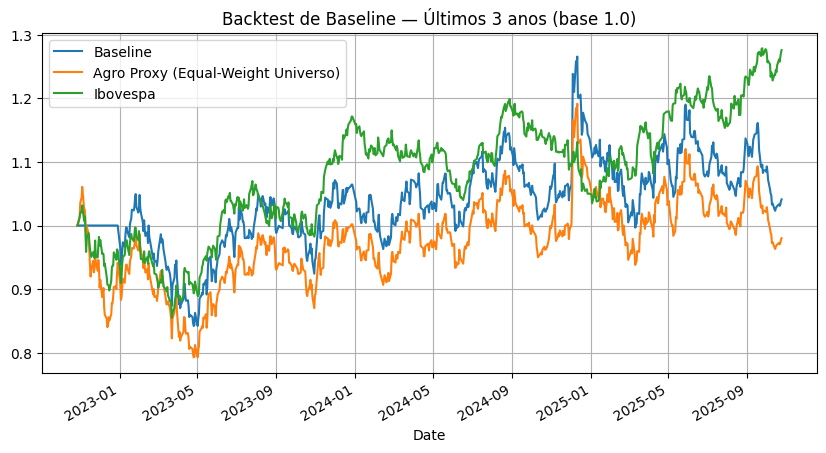

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
baseline_curve.plot(label="Baseline")
agro_proxy_curve.plot(label="Agro Proxy (Equal-Weight Universo)")
ibov_curve.plot(label="Ibovespa")
plt.title("Backtest de Baseline — Últimos 3 anos (base 1.0)")
plt.legend()
plt.grid(True)
plt.show()